# Imports:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
class MelDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.mel_paths = self.df["mel_npy_path"].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.mel_paths)

    def __getitem__(self, idx):
        mel = np.load(self.mel_paths[idx])  # Shape: (n_mels, time)
        mel = (mel - mel.min()) / (mel.max() - mel.min()) # Normalize to [0, 1]
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  # (1, n_mels, time)
        if self.transform:
            mel = self.transform(mel)
        return mel

In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.activation(x + self.block(x))

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_residual=True):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.residual = ResidualConvBlock(out_channels) if use_residual else nn.Identity()

    def forward(self, x):
        x = self.initial(x)
        return self.residual(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(2)
        )
    
    def forward(self, x):
        return self.block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.attn = SkipAttention(out_channels)
        self.conv = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape != skip.shape:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        skip = self.attn(skip)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class SkipAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv2d(channels, channels // 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 2, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, skip):
        return skip * self.attn(skip)



In [ ]:
class MelEncoder(nn.Module):
    def __init__(self, embedding_dim=1024):
        super().__init__()
        self.initial_conv = ConvBlock(1, 64)
        self.down1 = DownBlock(64, 128)   # -> (128, 64, 430)
        self.down2 = DownBlock(128, 256)  # -> (256, 32, 215)
        self.down3 = DownBlock(256, 512)  # -> (512, 16, 107)
        self.down4 = DownBlock(512, 1024) # -> (1024, 8, 53)

        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.proj = nn.Linear(1024 * 4 * 4, embedding_dim)

    def forward(self, x):
        skips = []

        x = self.initial_conv(x)
        skips.append(x)

        x = self.down1(x)
        skips.append(x)

        x = self.down2(x)
        skips.append(x)

        x = self.down3(x)
        skips.append(x)

        x = self.down4(x)

        x_pooled = self.pool(x)
        z = x_pooled.flatten(1)
        z = self.proj(z)

        return z, skips


In [ ]:
class MelDecoder(nn.Module):
    def __init__(self, embedding_dim=1024):
        super().__init__()
        self.fc = nn.Linear(embedding_dim, 1024 * 4 * 4)

        self.up1 = UpBlock(1024, 512)
        self.up2 = UpBlock(512, 256)
        self.up3 = UpBlock(256, 128)
        self.up4 = UpBlock(128, 64)
        self.up5 = UpBlock(64, 32)

        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z, skips):
        x = self.fc(z)
        x = x.view(-1, 1024, 4, 4)

        skips = skips[::-1]  # reverse skip order

        x = self.up1(x, skips[0][:, :, :8, :8])
        x = self.up2(x, skips[1][:, :, :16, :16])
        x = self.up3(x, skips[2][:, :, :32, :32])
        x = self.up4(x, skips[3][:, :, :64, :64])
        x = self.up5(x, skips[4][:, :, :128, :128])  # original resolution

        x = self.final_conv(x)
        x = F.interpolate(x, size=(128, 861), mode='bilinear', align_corners=True)
        return x


In [ ]:
class MelAutoencoder(nn.Module):
    def __init__(self, embedding_dim=1024):
        super().__init__()
        self.encoder = MelEncoder(embedding_dim)
        self.decoder = MelDecoder(embedding_dim)

    def forward(self, x):
        z, skips = self.encoder(x)
        return self.decoder(z, skips)


In [ ]:
def train_auto_encoder(model, train_loader, val_loader, epochs=200, checkpoint_dir='checkpoints/reference_encoder'):
    optimizer = optim.Adam(
        list(model.parameters()),
        lr=1e-3, weight_decay=1e-4  # L2 regularization term
    )

    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(1, epochs + 1):
        # ----- Training -----
        model.train()
        train_loss = 0
        for mel in train_loader:
            recon = model(mel)
            loss = F.l1_loss(recon, mel) + 0.1 * F.mse_loss(recon, mel)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # ----- Validation -----
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for mel in val_loader:
                recon = model(mel)
                loss = F.l1_loss(recon, mel)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # ----- Save checkpoint -----
        if epoch % 5 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")


In [21]:
train_df = pd.read_csv("Data/split_train_val/train_split.csv")
val_df = pd.read_csv("Data/split_train_val/val_split.csv")

train_df["mel_npy_path"] = train_df["mel_npy_path"].apply(lambda x: x.replace("\\", "/"))
val_df["mel_npy_path"] = val_df["mel_npy_path"].apply(lambda x: x.replace("\\", "/"))

train_dataset = MelDataset(csv_path="Data/split_train_val/train_split.csv")
val_dataset = MelDataset(csv_path="Data/split_train_val/val_split.csv")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

encoder = MelEncoder(embedding_dim=512).to(device)
decoder = MelDecoder(embedding_dim=512).to(device) 
autoencoder = MelAutoencoder(encoder=encoder, decoder=decoder).to(device)

train_auto_encoder(autoencoder, train_loader, val_loader, epochs=200)

cuda
Epoch 1, Train Loss: 0.1746, Validation Loss: 0.1293
Epoch 2, Train Loss: 0.0514, Validation Loss: 0.0493
Epoch 3, Train Loss: 0.0440, Validation Loss: 0.0431
Epoch 4, Train Loss: 0.0425, Validation Loss: 0.0511
Epoch 5, Train Loss: 0.0403, Validation Loss: 0.0518
Checkpoint saved to checkpoints/reference_encoder/checkpoint_epoch_5.pth
Epoch 6, Train Loss: 0.0394, Validation Loss: 0.0448
Epoch 7, Train Loss: 0.0384, Validation Loss: 0.0485
Epoch 8, Train Loss: 0.0382, Validation Loss: 0.0483
Epoch 9, Train Loss: 0.0380, Validation Loss: 0.0393
Epoch 10, Train Loss: 0.0380, Validation Loss: 0.0371
Checkpoint saved to checkpoints/reference_encoder/checkpoint_epoch_10.pth
Epoch 11, Train Loss: 0.0375, Validation Loss: 0.0517
Epoch 12, Train Loss: 0.0385, Validation Loss: 0.0463
Epoch 13, Train Loss: 0.0379, Validation Loss: 0.0452
Epoch 14, Train Loss: 0.0371, Validation Loss: 0.0460
Epoch 15, Train Loss: 0.0371, Validation Loss: 0.0785
Checkpoint saved to checkpoints/reference_encod

KeyboardInterrupt: 

In [23]:
def visualize_first_10(autoencoder, dataloader, device, checkpoint_path = 'checkpoints/reference_encoder/checkpoint_epoch_35.pth'):
    autoencoder.load_state_dict(torch.load(checkpoint_path, map_location=device))
    autoencoder.eval()

    with torch.no_grad():
        for batch in dataloader:
            original = batch.to(device)
            reconstructed = autoencoder(original)
            break  # Only take the first batch

    original = original.cpu()
    reconstructed = reconstructed.cpu()

    # Plot the first 10 samples
    for i in range(10):
        plt.figure(figsize=(10, 3))

        # Original
        plt.subplot(1, 2, 1)
        plt.imshow(original[i][0], aspect='auto', origin='lower', cmap='magma')
        plt.title(f'Original #{i+1}')
        plt.colorbar()

        # Reconstructed
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed[i][0], aspect='auto', origin='lower', cmap='magma')
        plt.title(f'Reconstructed #{i+1}')
        plt.colorbar()

        plt.tight_layout()
        plt.show()


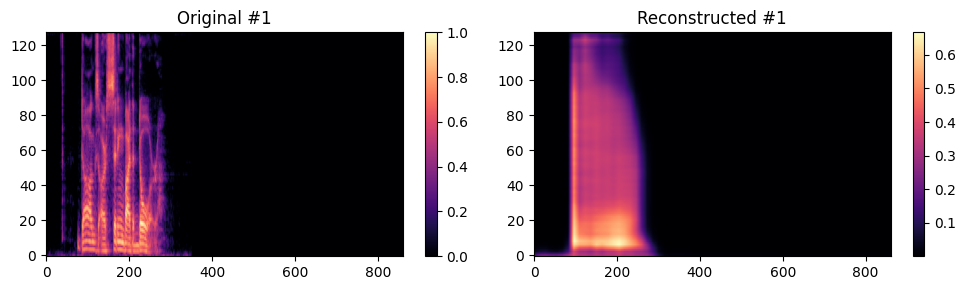

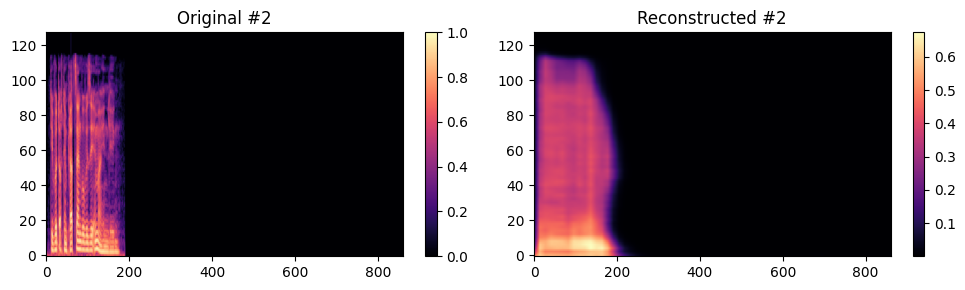

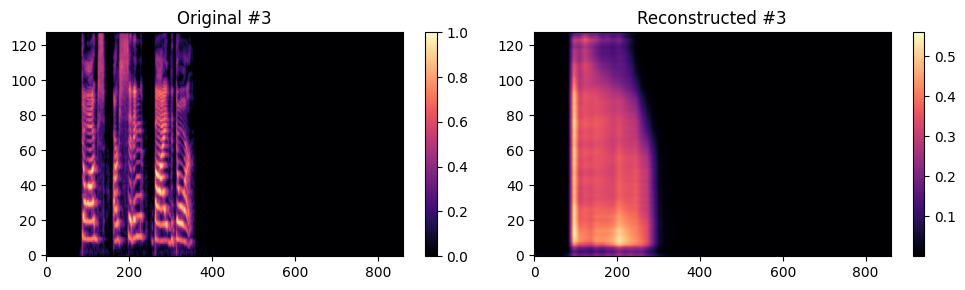

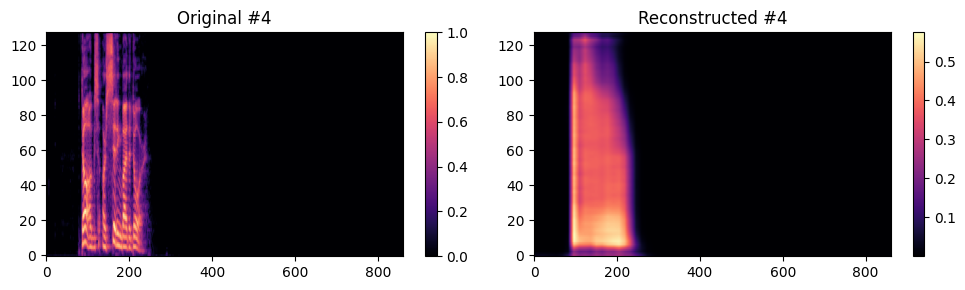

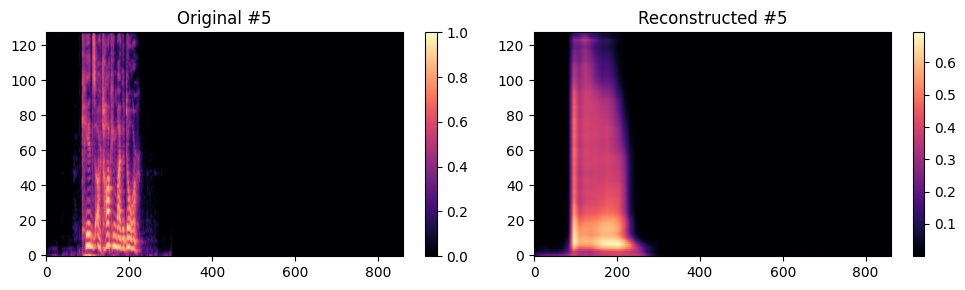

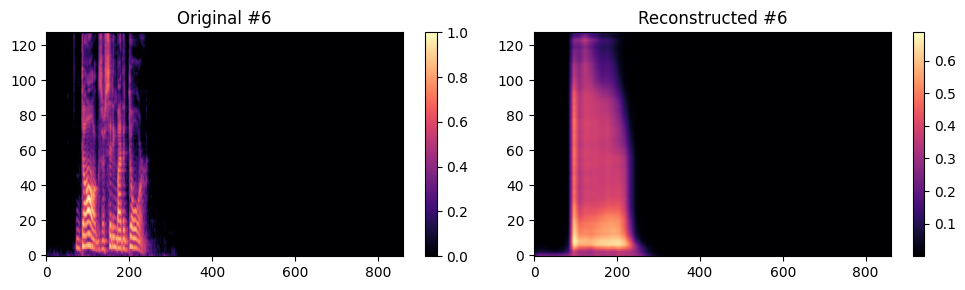

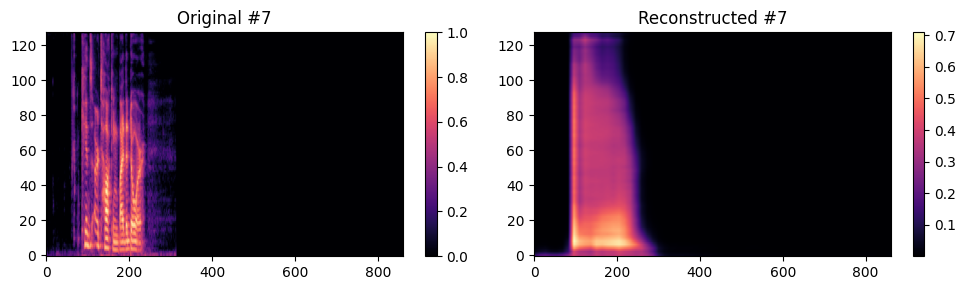

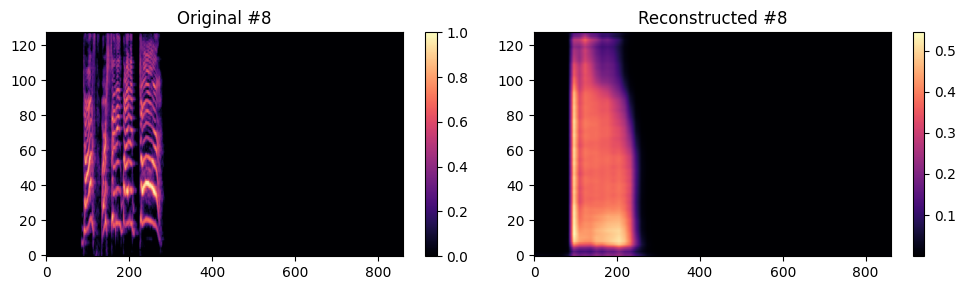

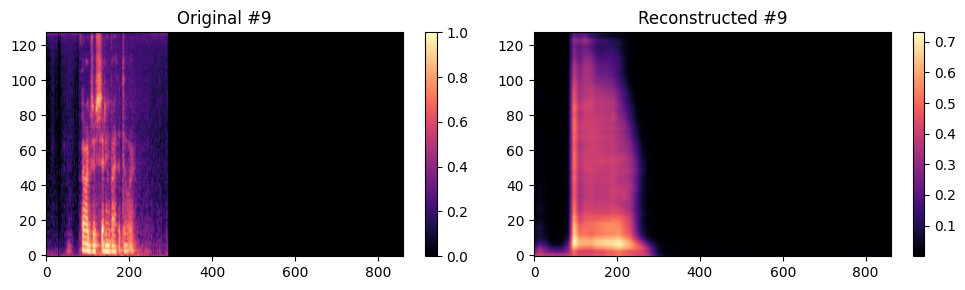

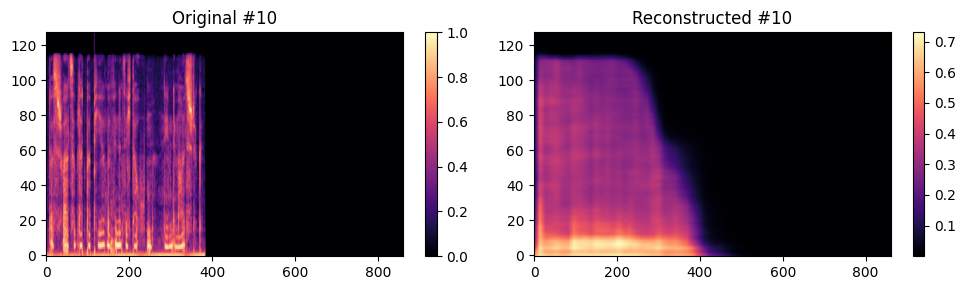

In [24]:
visualize_first_10(autoencoder, val_loader, device)
